In [25]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

from skimage.io import imread, imshow

#importeer Tensorflow namespaces
from keras.models import Sequential
from keras.layers import Activation
from keras.utils import np_utils
from keras.models import load_model
from keras.layers import Flatten, Dense
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.optimizers import SGD
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, ModelCheckpoint
#from keras.utils.np_utils import to_categorical

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

In [26]:
#GPU
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.80
set_session(tf.Session(config=config))

In [27]:
#read data
# define path variables
parent_path = os.path.dirname(os.getcwd())

data_path = os.path.join(parent_path,'compr' , 'data')
img_dir_path = os.path.join(data_path, 'img')
model_path = os.path.join(parent_path, 'model')
log_path = os.path.join(model_path, 'log')


csv_dir_path = os.path.join(data_path, 'csv')
train_file = os.path.join(csv_dir_path,'data.csv')
valid_file = os.path.join(csv_dir_path,'test.csv')

OUTPUT_NORMALIZATION = 655.35

In [28]:
df_train = pd.read_csv(os.path.join(data_path, train_file))
print("%d rows" % df_train.shape[0])
df_train.head(10)

24366 rows


,img,gametime,speed,gameSteer,gameThrottle,gameBrake,speedLimit
0,2018-01-24T21-23-3-406_image.png,2018-01-24T21-23-3-406,41.690517,-0.020368,0.171516,0.0,80
1,2018-01-24T21-23-3-627_image.png,2018-01-24T21-23-3-627,41.690440,-0.021409,0.171952,0.0,80
2,2018-01-24T21-23-3-606_image.png,2018-01-24T21-23-3-606,41.690918,-0.021532,0.172063,0.0,80
3,2018-01-24T21-23-3-819_image.png,2018-01-24T21-23-3-819,41.691322,-0.022773,0.172316,0.0,80
4,2018-01-24T21-23-3-805_image.png,2018-01-24T21-23-3-805,41.691113,-0.022877,0.172270,0.0,80
5,2018-01-24T21-23-4-5_image.png,2018-01-24T21-23-4-5,41.691340,-0.023167,0.173255,0.0,80
6,2018-01-24T21-23-4-25_image.png,2018-01-24T21-23-4-25,41.691208,-0.022852,0.173192,0.0,80
7,2018-01-24T21-23-4-206_image.png,2018-01-24T21-23-4-206,41.690800,-0.020487,0.173919,0.0,80
8,2018-01-24T21-23-4-291_image.png,2018-01-24T21-23-4-291,41.690178,-0.019397,0.174429,0.0,80
9,2018-01-24T21-23-4-406_image.png,2018-01-24T21-23-4-406,41.689120,-0.017389,0.175886,0.0,80


In [29]:
df_test = pd.read_csv(os.path.join(data_path, valid_file))
print("%d rows" % df_test.shape[0])
df_test.head(10)

6065 rows


,img,gametime,speed,gameSteer,gameThrottle,gameBrake,speedLimit
0,2018-01-24T21-12-39-291_image.png,2018-01-24T21-12-39-291,7.769772,0.017737,1.000000e+00,0,80
1,2018-01-24T21-12-39-458_image.png,2018-01-24T21-12-39-458,9.720881,0.019283,1.000000e+00,0,80
2,2018-01-24T21-12-39-647_image.png,2018-01-24T21-12-39-647,11.415665,0.018463,2.500000e-01,0,80
3,2018-01-24T21-12-39-823_image.png,2018-01-24T21-12-39-823,12.531712,0.017585,2.441410e-04,0,80
4,2018-01-24T21-12-39-998_image.png,2018-01-24T21-12-39-998,13.426690,0.016601,1.190000e-07,0,80
5,2018-01-24T21-12-40-175_image.png,2018-01-24T21-12-40-175,14.029332,0.015713,1.160000e-10,0,80
6,2018-01-24T21-12-40-339_image.png,2018-01-24T21-12-40-339,14.477673,0.014844,1.140000e-13,0,80
7,2018-01-24T21-12-40-512_image.png,2018-01-24T21-12-40-512,14.795598,0.015164,3.448595e-02,0,80
8,2018-01-24T21-12-40-692_image.png,2018-01-24T21-12-40-692,14.962753,0.014295,7.928709e-01,0,80
9,2018-01-24T21-12-40-859_image.png,2018-01-24T21-12-40-859,15.481391,0.013380,9.998989e-01,0,80


In [30]:
def img_to_arr(p):
    with image.load_img(p) as img:
        img = image.img_to_array(img)
    return img

def normalize(img):
    img[:,:,0] -= 94.9449
    img[:,:,0] /= 58.6121

    img[:,:,1] -= 103.599
    img[:,:,1] /= 61.6239

    img[:,:,2] -= 92.9077
    img[:,:,2] /= 68.66
    
    return img

In [31]:
# define generator that loops through the data
def generator(df, batch_size, img_shape, should_shuffle):
    # shuffle dataframe for each epoch
    if should_shuffle:
        df = shuffle(df)
        
    img_list = df['img']
    gameSteer = df['gameSteer']
    
    # create empty batch
    batch_img = np.zeros((batch_size,) + img_shape)
    batch_label = np.zeros((batch_size, 1))
    
    index = 0
    while True:
        for i in range(batch_size):
            img_name = img_list[index]
            arr = img_to_arr(os.path.join(img_dir_path, img_name))
            
            batch_img[i] = normalize(arr)
            batch_label[i] = gameSteer[index]
            
            index += 1
            if index == len(img_list):
                index = 0
            
        yield batch_img, batch_label

In [32]:
input_shape = img_to_arr(os.path.join(img_dir_path, df_train['img'][0])).shape
batch_size = 40
train_steps = (df_train.shape[0] / batch_size) + 1
val_steps = (df_test.shape[0] / batch_size) + 1

print("input_shape: %s, batch_size: %d, train_steps: %d, val_steps: %d" % 
      (input_shape, batch_size, train_steps, val_steps))

input_shape: (320, 427, 3), batch_size: 40, train_steps: 610, val_steps: 152


In [33]:
train_batch = generator(df_train, batch_size, input_shape, True)
test_batch = generator(df_test, batch_size, input_shape, False)

In [34]:
# Define model, includes batch normalisation

def get_model(input_shape):
    model = Sequential([
        Conv2D(24, kernel_size=(5,5), strides=(2,2), activation='relu', input_shape=input_shape),
        BatchNormalization(axis=1),
        Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='relu'),
        BatchNormalization(axis=1),
        Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='relu'),
        BatchNormalization(axis=1),
        Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu'),
        BatchNormalization(axis=1),
        Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu'),
        BatchNormalization(axis=1),
        Flatten(),
        Dense(100, activation='relu'),
        BatchNormalization(),
        Dense(50, activation='relu'),
        BatchNormalization(),
        Dense(10, activation='relu'),
        BatchNormalization(),
        Dense(1)
    ])
    
    return model

model = get_model(input_shape)
sgd = SGD(lr=1e-3, decay=1e-4, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss="mse") 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 158, 212, 24)      1824      
_________________________________________________________________
batch_normalization_17 (Batc (None, 158, 212, 24)      632       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 77, 104, 36)       21636     
_________________________________________________________________
batch_normalization_18 (Batc (None, 77, 104, 36)       308       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 37, 50, 48)        43248     
_________________________________________________________________
batch_normalization_19 (Batc (None, 37, 50, 48)        148       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 35, 48, 64)        27712     
__________

In [35]:
# define callbacks
cur_model = '-PilotNet_v2'
csv_logger = CSVLogger(os.path.join(log_path, cur_model + '.log'))

model_file_name= os.path.join(model_path, cur_model + '-{epoch:03d}-{val_loss:.5f}.h5')
checkpoint = ModelCheckpoint(model_file_name, verbose=0, save_best_only=True)

In [36]:
history = model.fit_generator(train_batch, 
                    train_steps, 
                    epochs=10, 
                    verbose=1, 
                    callbacks=[csv_logger, checkpoint], 
                    validation_data=test_batch, 
                    validation_steps=val_steps, 
                    initial_epoch=0)


Epoch 1/10
611/610 [==============================] - 327s 536ms/step - loss: 0.0742 - val_loss: 0.6024
Epoch 2/10
611/610 [==============================] - 319s 522ms/step - loss: 0.0038 - val_loss: 0.1394
Epoch 3/10
611/610 [==============================] - 331s 542ms/step - loss: 0.0023 - val_loss: 0.0624
Epoch 4/10
611/610 [==============================] - 321s 525ms/step - loss: 0.0016 - val_loss: 0.0739
Epoch 5/10
611/610 [==============================] - 317s 518ms/step - loss: 0.0013 - val_loss: 0.0584
Epoch 6/10
611/610 [==============================] - 330s 540ms/step - loss: 0.0011 - val_loss: 0.1381
Epoch 7/10
611/610 [==============================] - 320s 524ms/step - loss: 9.4971e-04 - val_loss: 0.0157
Epoch 8/10
611/610 [==============================] - 331s 541ms/step - loss: 8.7234e-04 - val_loss: 0.0171
Epoch 9/10
611/610 [==============================] - 320s 524ms/step - loss: 8.2617e-04 - val_loss: 0.0174
Epoch 10/10
611/610 [==============================]

In [37]:
scoreTrain = model.evaluate_generator(train_batch, df_train.shape[0] / batch_size)
score = model.evaluate_generator(test_batch, df_test.shape[0] / batch_size)
print("trainScore", scoreTrain)
print("testScore", score)

trainScore 0.0479920112447
testScore 0.0207360237873


In [38]:
predictions = model.predict_generator(test_batch, df_test.shape[0] / batch_size)
print(predictions)
print(df_test['gameSteer'])

[[-0.08278009]
 [-0.12072416]
 [-0.12187521]
 ..., 
 [-0.15230885]
 [-0.16335794]
 [-0.15830314]]
0       0.017737
1       0.019283
2       0.018463
3       0.017585
4       0.016601
5       0.015713
6       0.014844
7       0.015164
8       0.014295
9       0.013380
10      0.012484
11      0.011677
12      0.010713
13      0.009838
14      0.009055
15      0.006326
16      0.000470
17      0.000428
18      0.000384
19      0.000344
20      0.000308
21      0.000249
22      0.000222
23      0.000199
24      0.000179
25      0.000158
26      0.000141
27      0.002560
28      0.002378
29      0.002258
          ...   
6035   -0.020756
6036   -0.020756
6037   -0.020196
6038   -0.019922
6039   -0.015579
6040   -0.015367
6041   -0.014953
6042   -0.014953
6043   -0.014953
6044   -0.014750
6045   -0.020190
6046   -0.021011
6047   -0.022533
6048   -0.023637
6049   -0.023316
6050   -0.023316
6051   -0.021190
6052   -0.019522
6053   -0.018996
6054   -0.016570
6055   -0.016124
6056   -0.014065
6

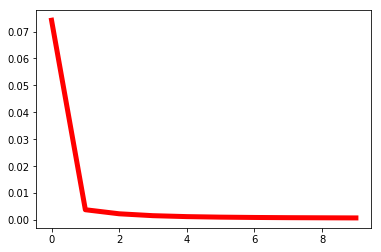

In [39]:
plt.plot(history.history['loss'],'red',linewidth=5.0)